### Import necessary modules

In [24]:
from pathlib import Path

DATASET_DIR = Path("../data/err-0.5")

MODEL = "ufal/robeczech-base"
BATCH_SIZE = 32
EPOCHS = 3

### Load data

Load dataset with errored sentences

In [25]:
from datasets import Dataset, DatasetDict

train = Dataset.from_json(str(DATASET_DIR / "train.json"))
validate = Dataset.from_json(str(DATASET_DIR / "validate.json"))

dataset = DatasetDict({"train": train, "validate": validate})

dataset

Generating train split: 80000 examples [00:00, 858942.88 examples/s]
Generating train split: 10000 examples [00:00, 1038888.37 examples/s]


DatasetDict({
    train: Dataset({
        features: ['sentence', 'error', 'labels'],
        num_rows: 80000
    })
    validate: Dataset({
        features: ['sentence', 'error', 'labels'],
        num_rows: 10000
    })
})

In [26]:
LABEL_LIST = [0, 1]

### Load RoBERTa model tokenizer

Load Czech RoBERTa model tokenizer from huggingface

In [27]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained(MODEL, add_prefix_space=True)

### Examples how the data will be tokenized

In [48]:
example = dataset["train"][4]
print(example)

{'sentence': ['Umožňuje', 'buňce', 'recyklovat', 'staré', 'buněčné', 'komponenty', 'či', 'nefunkční', 'proteiny', 'a', 'představuje', 'nouzový', 'zdroj', 'energie', 've', 'stresových', 'podmínkách'], 'error': ['Umožňuje', 'buňce', 'recyklovat', 'staré', 'buněčné', 'komponenty', 'čččči', 'nefunkční', 'proteiny', 'a', 'představuje', 'nouzový', 'zdrojs', 'energie', 've', 'tresových', 'podmínkác'], 'labels': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1]}


In [29]:
tokenized_input = tokenizer(example["error"],  is_split_into_words=True)
tokenized_input

{'input_ids': [0, 340, 35080, 1556, 22467, 107, 33456, 138, 3311, 1973, 41903, 1820, 32374, 1071, 249, 249, 547, 41677, 8921, 805, 6, 1939, 19206, 24027, 4718, 98, 2128, 22, 6188, 98, 294, 50502, 559, 206, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [47]:
print(tokenized_input.tokens())

['[CLS]', 'ĠU', 'moÅ¾', 'ÅĪuje', 'ĠbuÅĪ', 'ce', 'Ġrecy', 'k', 'lovat', 'ĠstarÃ©', 'ĠbunÄĽ', 'ÄįnÃ©', 'Ġkomponenty', 'ĠÄį', 'Äį', 'Äį', 'Äįi', 'ĠnefunkÄįnÃŃ', 'Ġprote', 'iny', 'Ġa', 'ĠpÅĻedstavuje', 'Ġnou', 'zovÃ½', 'Ġzdroj', 's', 'Ġenergie', 'Ġve', 'Ġtre', 's', 'ovÃ½ch', 'ĠpodmÃŃn', 'kÃ¡', 'c', '[SEP]']


In [46]:
print(tokenized_input.word_ids())

[None, 0, 0, 0, 1, 1, 2, 2, 2, 3, 4, 4, 5, 6, 6, 6, 6, 7, 8, 8, 9, 10, 11, 11, 12, 12, 13, 14, 15, 15, 15, 16, 16, 16, None]


### Process dataset

Here we set the labels of all special tokens to `-100` (the index that is ignored by PyTorch) and the labels of all other tokens to the label of the word they come from.

In [32]:
label_all_tokens = True

Define function that will preprocess our samples. We feed them to the tokenizer with the argument `truncation=True` (to truncate texts that are bigger than the maximum size allowed by the model) and `is_split_into_words=True` (as seen above). Then we align the labels with the token ids.

In [33]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["error"], is_split_into_words=True, truncation=True, padding="max_length", max_length=128)

    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            # Special tokens have a word id that is None. We set the label to -100 so they are automatically
            # ignored in the loss function.
            if word_idx is None:
                label_ids.append(-100)
            # We set the label for the first token of each word.
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # For the other tokens in a word, we set the label to either the current label or -100, depending on
            # the label_all_tokens flag.
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [34]:
tokenize_and_align_labels(dataset['train'][:2])

{'input_ids': [[0, 12715, 166, 922, 974, 1039, 1270, 906, 4969, 41874, 3048, 560, 1895, 6, 31255, 50139, 698, 165, 279, 371, 51006, 4400, 11930, 444, 23425, 34470, 12, 1777, 17, 31255, 50139, 613, 539, 39093, 11848, 675, 8, 24254, 16237, 48, 16346, 2329, 29, 10693, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 8886, 6420, 397, 1141, 3962, 47353, 9256, 163, 2384, 14457, 11968, 595, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [35]:
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True, num_proc=4)

Map (num_proc=4): 100%|██████████| 10000/10000 [00:00<00:00, 22589.55 examples/s]


### Fine-tuning the model

Now that our data is ready, we can download pretrained model and fine-tune it.

In [36]:
from transformers import RobertaForTokenClassification

# num labels should be 2 (valid and error)
model = RobertaForTokenClassification.from_pretrained(MODEL, num_labels=2)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at ufal/robeczech-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We need to specify training arguments. It requires one folder name, which will be used to save the checkpoints of the model, others are optional.

In [37]:
from transformers import TrainingArguments

args = TrainingArguments(
    f"{MODEL}-finetuned-error-detection",
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    optim="adamw_torch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    fp16=True,
)

We will need a data collator that will batch our processed examples together while applying padding to make them all the same size (each pad will be padded to the length of its longest example). There is a data collator for this task in the Transformers library, that not only pads the inputs, but also the labels.

In [38]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(tokenizer)

The last thing to define for our Trainer is how to compute the metrics from the predictions. Here we will use `classification_report`.

In [39]:
from sklearn.metrics import classification_report

So we will need to do a bit of post-processing on our predictions:

- select the predicted index (with the maximum logit) for each token
- convert it to its string label
- ignore everywhere we set a label of `-100`

In [40]:

import numpy as np

def compute_binary_classification_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [LABEL_LIST[p] for (p, l) in zip(prediction, label) if l != -100]  # noqa: E741
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [LABEL_LIST[l] for (_, l) in zip(prediction, label) if l != -100]  # noqa: E741
        for prediction, label in zip(predictions, labels)
    ]

    # Flatten lists for easier processing
    true_predictions_flat = [item for sublist in true_predictions for item in sublist]
    true_labels_flat = [item for sublist in true_labels for item in sublist]

    # Calculate metrics
    report = classification_report(true_labels_flat, true_predictions_flat, output_dict=True, zero_division=0)

    return {
        "precision": report["macro avg"]["precision"],
        "recall": report["macro avg"]["recall"],
        "f1": report["macro avg"]["f1-score"],
        "accuracy": report["accuracy"]
    }

We drop the `precision/recall/f1` computed for each category and only focus on the overall `precision/recall/f1/accuracy`.

We just need to pass all of this along with our datasets to the `Trainer`.

In [ ]:
from transformers import Trainer



trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validate"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_binary_classification_metrics
)

In [42]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.068900,0.068051,0.975446,0.954544,0.964528,0.976724
2,0.060200,0.064460,0.976432,0.962129,0.969062,0.979557
3,0.038200,0.066722,0.976145,0.962612,0.969183,0.979621


TrainOutput(global_step=7500, training_loss=0.06594110714594523, metrics={'train_runtime': 2331.4642, 'train_samples_per_second': 102.94, 'train_steps_per_second': 3.217, 'total_flos': 1.567780540416e+16, 'train_loss': 0.06594110714594523, 'epoch': 3.0})

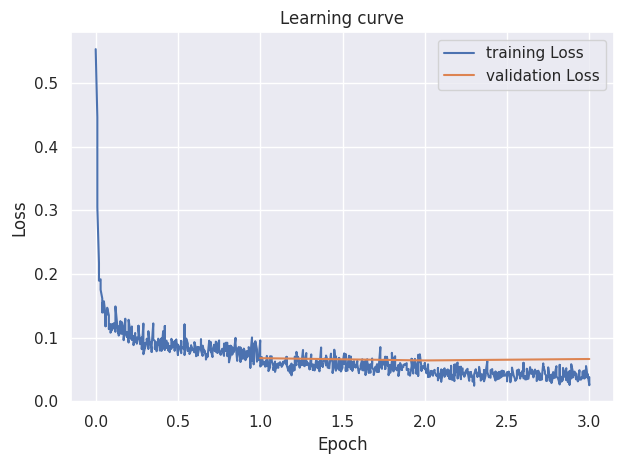

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

logs = [log for log in trainer.state.log_history if "eval_loss" not in log]
eval_logs = [log for log in trainer.state.log_history if "eval_loss" in log]

df = pd.DataFrame(logs)
df2 = pd.DataFrame(eval_logs)

loss = df["loss"]
val_loss = df2["eval_loss"]


sns.set_theme(style='darkgrid')

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot training loss
plt.plot(df["epoch"], loss, label="training Loss")

# Plot validation loss
plt.plot(df2["epoch"], val_loss, label="validation Loss")

# Add labels and title
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning curve")

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

In [44]:
model.save_pretrained("./model/roberta-error-detection", from_pt=True)
tokenizer.save_pretrained("./model/roberta-error-detection", from_pt=True)

('./model/roberta-error-detection/tokenizer_config.json',
 './model/roberta-error-detection/special_tokens_map.json',
 './model/roberta-error-detection/vocab.json',
 './model/roberta-error-detection/merges.txt',
 './model/roberta-error-detection/added_tokens.json',
 './model/roberta-error-detection/tokenizer.json')